[1] Import & Global Settings

In [ ]:
# 📦 필수 라이브러리 로드
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, classification_report, f1_score
)
import matplotlib.pyplot as plt
import copy

[2] 데이터 로딩 함수 + Dataset 구성

In [ ]:
# 📂 데이터 로딩 및 전처리 함수
def load_data(file_path="/content/data.csv", batch_size=64):
    df = pd.read_csv(file_path)

    # ✅ 주요 수정 사항: bool → float 처리 (자동 변환)
    for col in df.columns:
        if df[col].dtype == 'bool':
            df[col] = df[col].astype(float)

    # 이진 타겟 형태로 보장 (추가 안전장치)
    if df['y'].dtype != 'int':
        df['y'] = df['y'].astype(int)

    # X, y 분리
    X = df.drop(columns=['y'])
    y = df['y']

    # ✅ float 변환 (혹시 object 타입 남은 경우 대비)
    X = X.astype(float)

    # Train/Val/Test 분할
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    X_train_sub, X_val, y_train_sub, y_val = train_test_split(
        X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
    )

    # PyTorch Dataset 정의
    from torch.utils.data import Dataset, DataLoader

    class BankDataset(Dataset):
        def __init__(self, X, y):
            self.X = torch.tensor(X.values, dtype=torch.float32)
            self.y = torch.tensor(y.values, dtype=torch.float32)

        def __len__(self):
            return len(self.y)

        def __getitem__(self, idx):
            return self.X[idx], self.y[idx]

    # Dataloader 생성
    train_dataset = BankDataset(X_train_sub, y_train_sub)
    val_dataset   = BankDataset(X_val, y_val)
    test_dataset  = BankDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    input_dim = X.shape[1]
    return train_loader, val_loader, test_loader, input_dim

 [3] 모델 정의 함수

In [ ]:
# 🔧 MLPClassifier 모델 정의 함수
class MLPClassifier(nn.Module):
    def __init__(self, input_dim):
        super(MLPClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

[4] 훈련 함수, 평가 함수, 시각화 함수

In [ ]:
# 📈 Train 함수 정의
def train_model(model, train_loader, val_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device).view(-1, 1)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation Loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device).view(-1, 1)
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item()

    return total_loss / len(train_loader), val_loss / len(val_loader)

# 📊 Evaluation 함수
def evaluate_model(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            preds = model(xb).cpu().numpy()
            all_preds.extend(preds.flatten())
            all_labels.extend(yb.numpy())
    return np.array(all_labels), np.array(all_preds)

# 📈 학습곡선 시각화
def plot_learning_curve(train_losses, val_losses):
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title("Learning Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

# 📑 성능 출력 함수
def print_metrics(y_true, y_pred, y_prob):
    print("\n📌 Classification Report:")
    print(classification_report(y_true, y_pred))
    print(f"✅ Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"✅ Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"✅ Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"✅ F1-score: {f1_score(y_true, y_pred):.4f}")
    print(f"✅ ROC AUC: {roc_auc_score(y_true, y_prob):.4f}")
    print("\n📌 Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

[5] 메인 실행 코드 (모델 훈련 및 평가)

[Epoch 1] Train Loss: 0.3210 | Val Loss: 0.2907
[Epoch 2] Train Loss: 0.2934 | Val Loss: 0.2809
[Epoch 3] Train Loss: 0.2909 | Val Loss: 0.2808
[Epoch 4] Train Loss: 0.2874 | Val Loss: 0.2778
[Epoch 5] Train Loss: 0.2861 | Val Loss: 0.2774
[Epoch 6] Train Loss: 0.2873 | Val Loss: 0.2777
[Epoch 7] Train Loss: 0.2858 | Val Loss: 0.2772
[Epoch 8] Train Loss: 0.2848 | Val Loss: 0.2764
[Epoch 9] Train Loss: 0.2829 | Val Loss: 0.2769
[Epoch 10] Train Loss: 0.2832 | Val Loss: 0.2761
[Epoch 11] Train Loss: 0.2815 | Val Loss: 0.2766
[Epoch 12] Train Loss: 0.2817 | Val Loss: 0.2771
[Epoch 13] Train Loss: 0.2807 | Val Loss: 0.2753
[Epoch 14] Train Loss: 0.2807 | Val Loss: 0.2755
[Epoch 15] Train Loss: 0.2797 | Val Loss: 0.2779
[Epoch 16] Train Loss: 0.2800 | Val Loss: 0.2767
[Epoch 17] Train Loss: 0.2789 | Val Loss: 0.2758
[Epoch 18] Train Loss: 0.2786 | Val Loss: 0.2755
🛑 Early stopping triggered at epoch 18

✅ Best Model saved at epoch 13, Val Loss: 0.2753


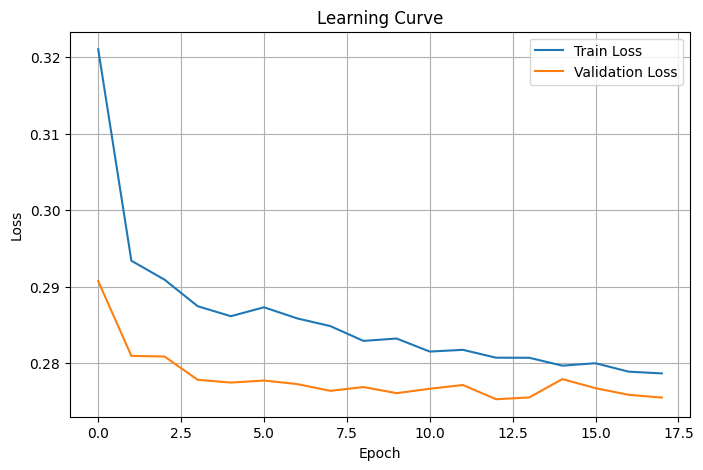

In [ ]:
# ⚙ 하이퍼파라미터 설정
num_epochs = 50
patience = 5
learning_rate = 0.001
batch_size = 64
model_path = "best_model.pth"

# 데이터 로딩
train_loader, val_loader, test_loader, input_dim = load_data(batch_size=batch_size)

# 모델/손실/옵티마이저 초기화
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPClassifier(input_dim).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 학습 초기화
train_losses, val_losses = [], []
best_val_loss = float('inf')
best_epoch = 0
patience_counter = 0
best_weights = copy.deepcopy(model.state_dict())

# 모델 학습 (EarlyStopping 포함)
for epoch in range(1, num_epochs + 1):
    train_loss, val_loss = train_model(model, train_loader, val_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"[Epoch {epoch}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        best_weights = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), model_path)
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"🛑 Early stopping triggered at epoch {epoch}")
            break

print(f"\n✅ Best Model saved at epoch {best_epoch}, Val Loss: {best_val_loss:.4f}")
plot_learning_curve(train_losses, val_losses)

[6] Best 모델 불러오기 및 최종 평가

In [ ]:
# ✅ Best 모델 로딩 및 테스트 평가
model.load_state_dict(torch.load(model_path))
y_true, y_prob = evaluate_model(model, test_loader, device)
y_pred = (y_prob >= 0.5).astype(int)
print_metrics(y_true, y_pred, y_prob)


📌 Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95      7310
         1.0       0.69      0.25      0.36       928

    accuracy                           0.90      8238
   macro avg       0.80      0.62      0.66      8238
weighted avg       0.89      0.90      0.88      8238

✅ Accuracy: 0.9028
✅ Precision: 0.6930
✅ Recall: 0.2457
✅ F1-score: 0.3628
✅ ROC AUC: 0.8035

📌 Confusion Matrix:
[[7209  101]
 [ 700  228]]


<ipython-input-26-beae9ad5eaf4>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
